In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import graphviz
from IPython.display import display, Markdown
import seaborn as sns

import os
project_dir = os.getcwd()
graphviz_bin_path = os.path.join(project_dir, "bin")
os.environ["PATH"] += os.pathsep + graphviz_bin_path

# Read data from a CSV file

In [2]:
file_path = 'data/wdbc.csv'
data = pd.read_csv(file_path, sep=',')

def classify_state(state):
    return "Malignant" if state == 'M' else "Benign"

features = data.drop('Diagnosis', axis=1)
labels = data['Diagnosis'].apply(classify_state)

print("Dataset Info:")
print(f"Samples: {len(data)}, Features: {len(features.columns)}")
print("\nQuality distribution:")
print(labels.value_counts().sort_index())

Dataset Info:
Samples: 569, Features: 30

Quality distribution:
Diagnosis
Benign       357
Malignant    212
Name: count, dtype: int64


# Split the data into train and test sets

In [3]:
def create_stratified_splits(features, labels, test_sizes):
    splits = {}
    for test_size in test_sizes:
        feature_train, feature_test, label_train, label_test = train_test_split(
            features, labels, 
            test_size=test_size, 
            random_state=42,
            stratify=labels
        )
        split_name = f"train_{100-int(test_size*100)}_test_{int(test_size*100)}"
        splits[split_name] = {
            'feature_train': feature_train,
            'label_train': label_train,
            'feature_test': feature_test,
            'label_test': label_test
        }
    return splits

test_sizes = [0.6, 0.4, 0.2, 0.1]
splits = create_stratified_splits(features, labels, test_sizes)

# Visualize the class distributions in all datasets

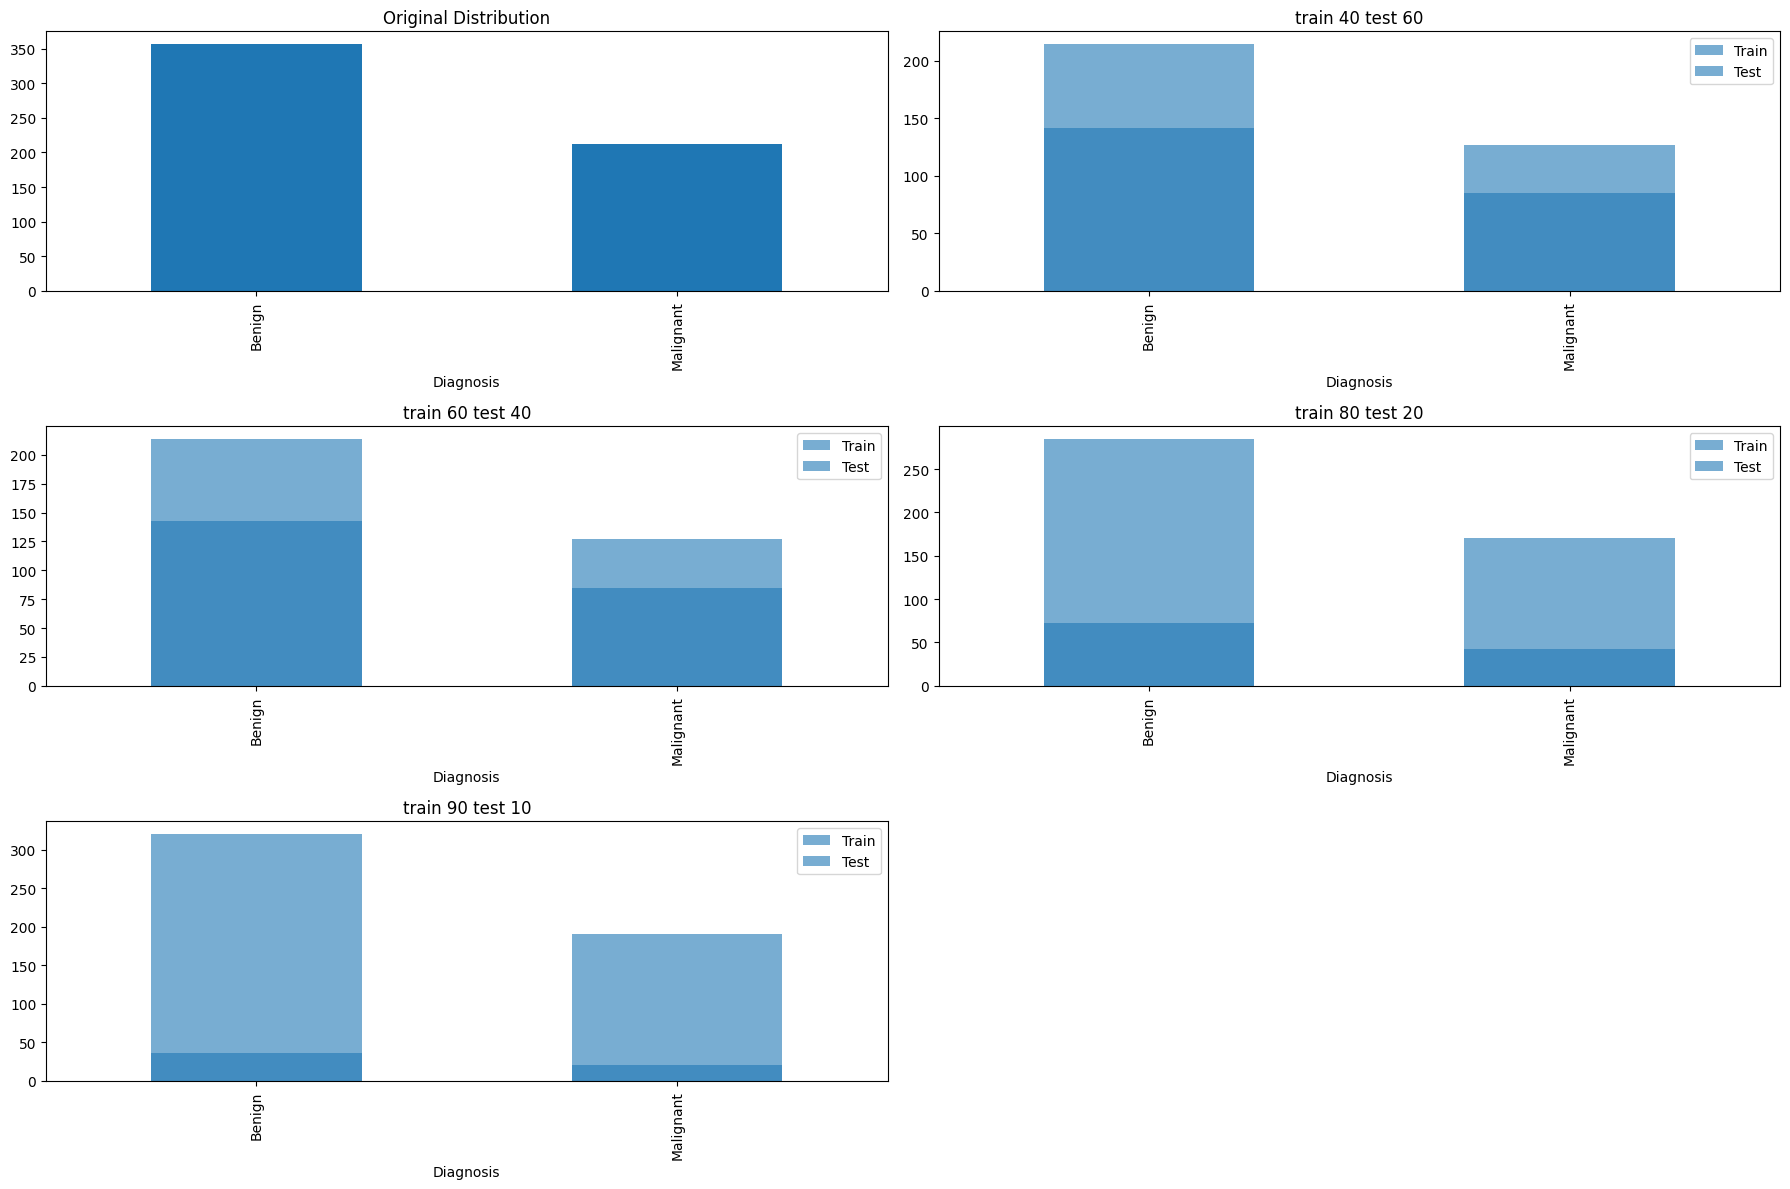

In [4]:
plt.figure(figsize=(18, 12))
plt.subplot(3, 2, 1)
labels.value_counts().sort_index().plot(kind='bar')
plt.title('Original Distribution')

for i, (name, data) in enumerate(splits.items(), 2):
    plt.subplot(3, 2, i)
    data['label_train'].value_counts().sort_index().plot(kind='bar', alpha=0.6, label='Train')
    data['label_test'].value_counts().sort_index().plot(kind='bar', alpha=0.6, label='Test')
    plt.title(name.replace('_', ' '))
    plt.legend()

plt.tight_layout()
plt.show()

# Building the decision tree classifiers

In [5]:
def evaluate_tree(feature_train, label_train, feature_test, label_test, max_depth=None):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(feature_train, label_train)
    predictions = dt.predict(feature_test)

    dot_data = export_graphviz(
        dt,
        out_file=None,
        feature_names=feature_train.columns,
        class_names=[str(x) for x in sorted(label_train.unique())],
        filled=True,
        rounded=True
    )
    display(graphviz.Source(dot_data))

    report = classification_report(label_test, predictions, target_names=sorted(label_train.unique()))
    acc = accuracy_score(label_test, predictions)
    cm = confusion_matrix(label_test, predictions, labels=sorted(label_train.unique()))
    
    display(Markdown(f"### 📋 Classification Report"))
    print(report)
    print(f"Accuracy: {acc:.2f}")

    display(Markdown(f"### 📊 Confusion Matrix"))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                xticklabels=sorted(label_train.unique()), yticklabels=sorted(label_train.unique()))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Decision Tree Classifier confusion matrix")
    plt.tight_layout()
    plt.show()

    return dt


#  Evaluating the decision tree classifiers

Evaluating all splits...

--------------------------------------------------
Evaluating train 40 test 60


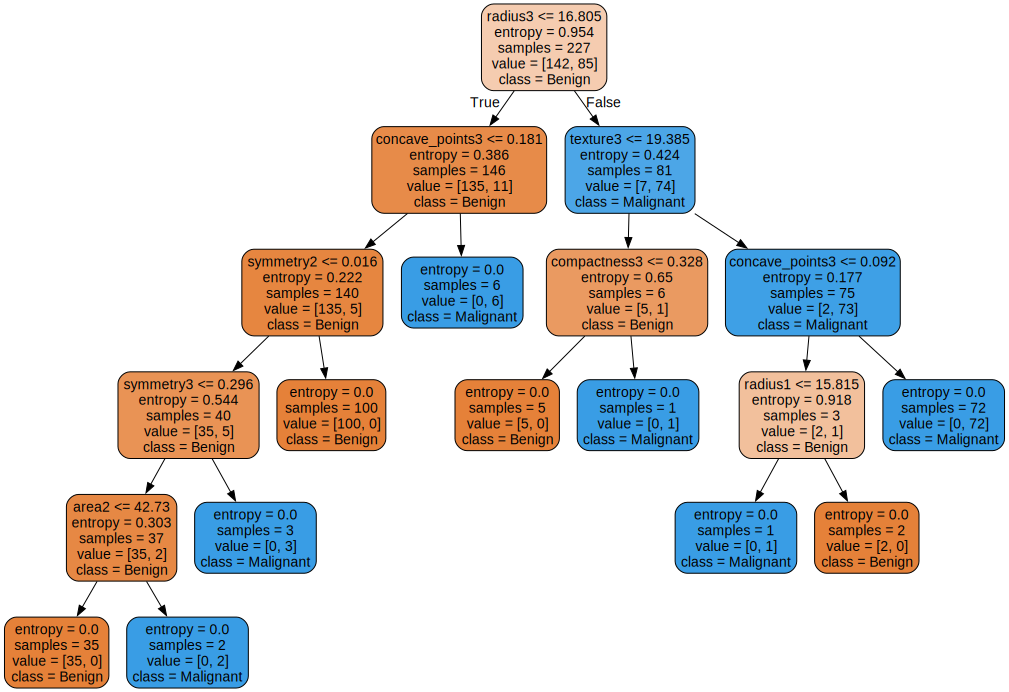

### 📋 Classification Report

              precision    recall  f1-score   support

      Benign       0.91      0.96      0.93       215
   Malignant       0.92      0.83      0.88       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342

Accuracy: 0.91


### 📊 Confusion Matrix

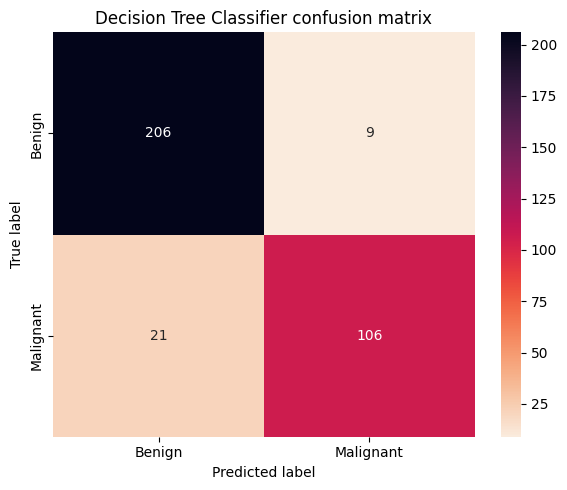


--------------------------------------------------
Evaluating train 60 test 40


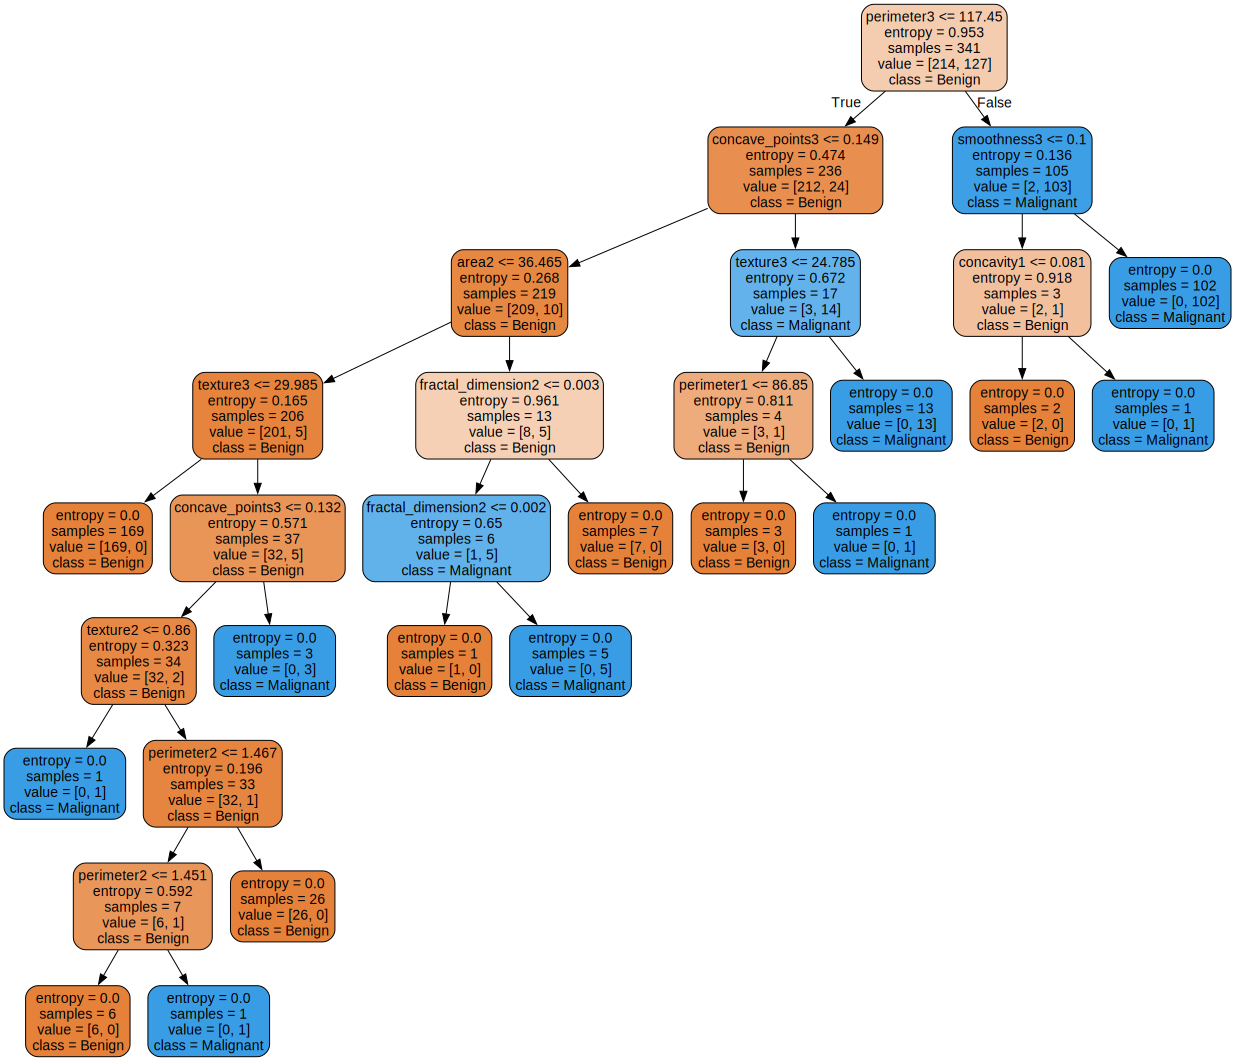

### 📋 Classification Report

              precision    recall  f1-score   support

      Benign       0.94      0.96      0.95       143
   Malignant       0.93      0.91      0.92        85

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228

Accuracy: 0.94


### 📊 Confusion Matrix

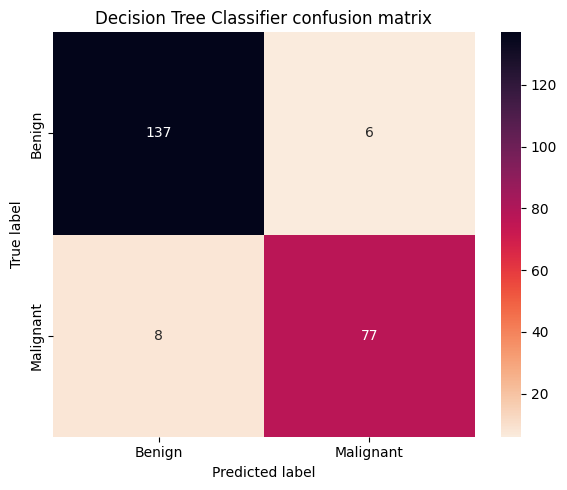


--------------------------------------------------
Evaluating train 80 test 20


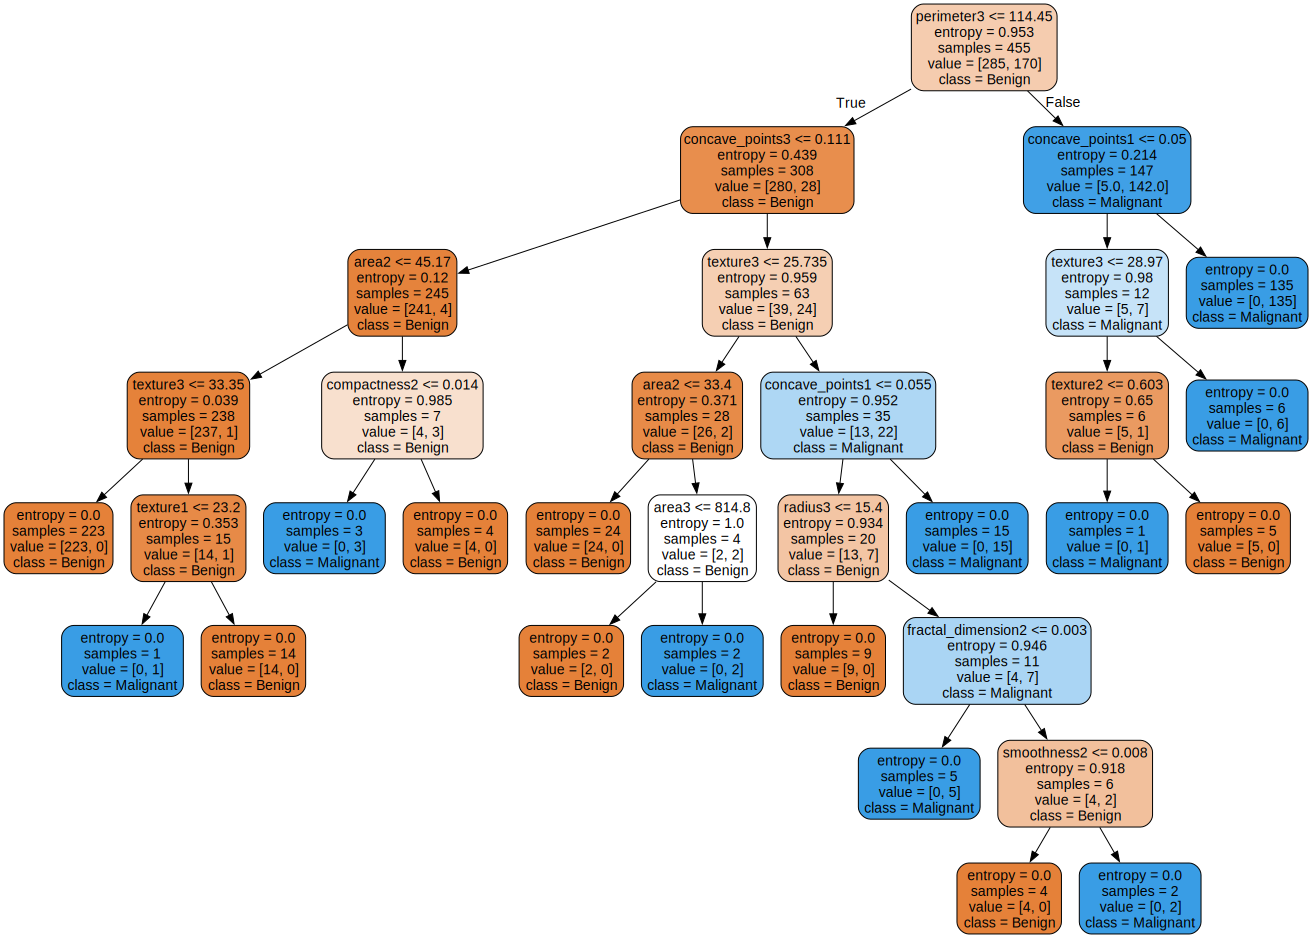

### 📋 Classification Report

              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97        72
   Malignant       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Accuracy: 0.96


### 📊 Confusion Matrix

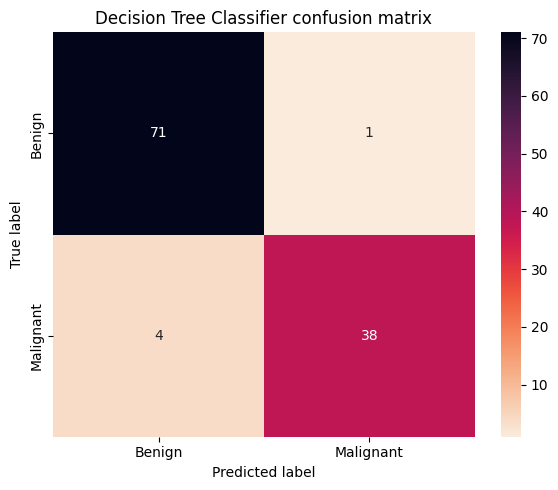


--------------------------------------------------
Evaluating train 90 test 10


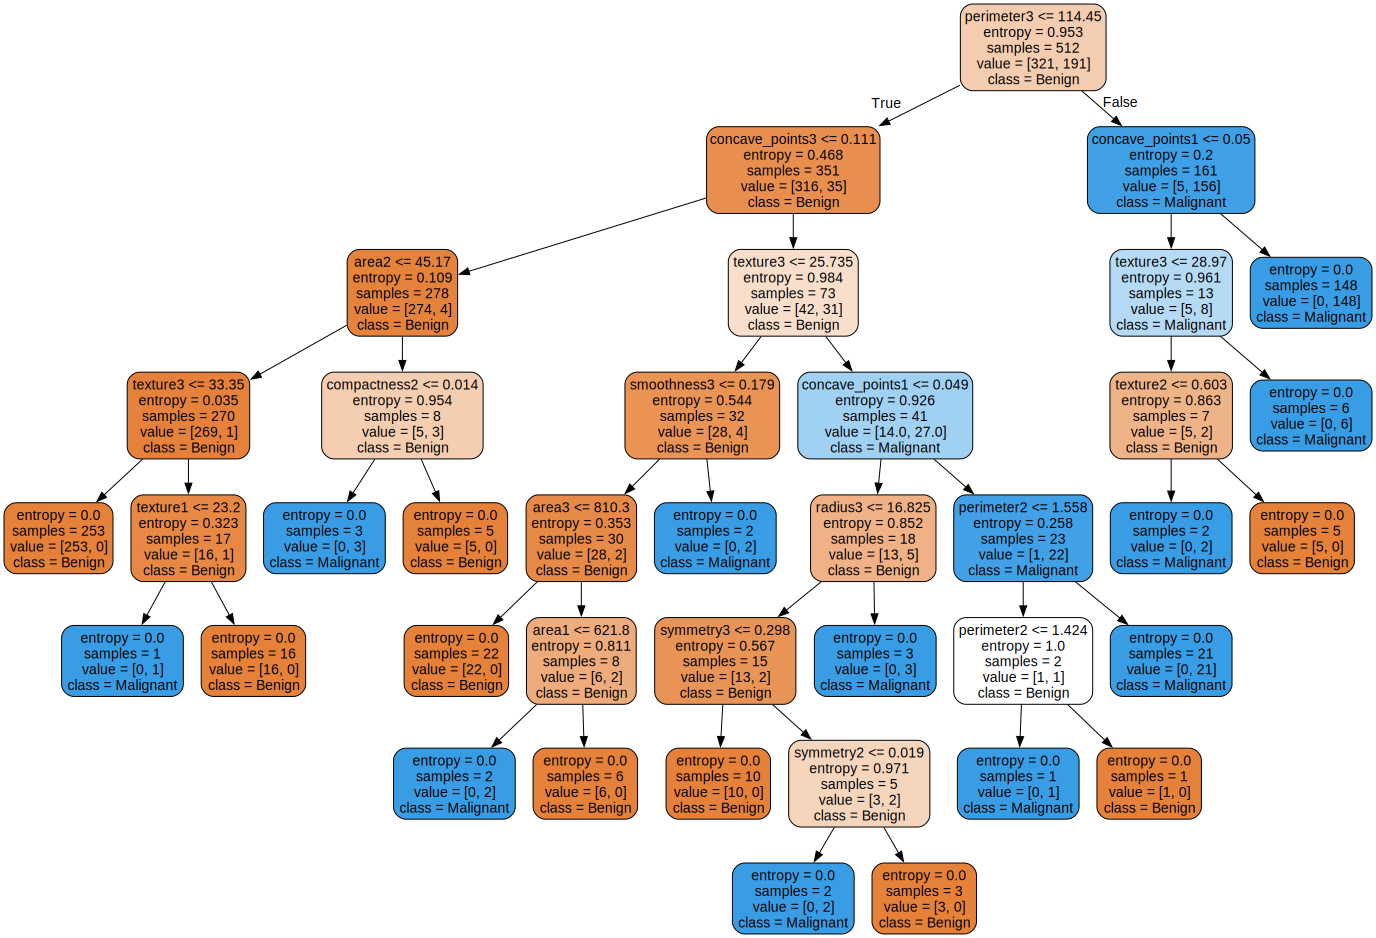

### 📋 Classification Report

              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96        36
   Malignant       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57

Accuracy: 0.95


### 📊 Confusion Matrix

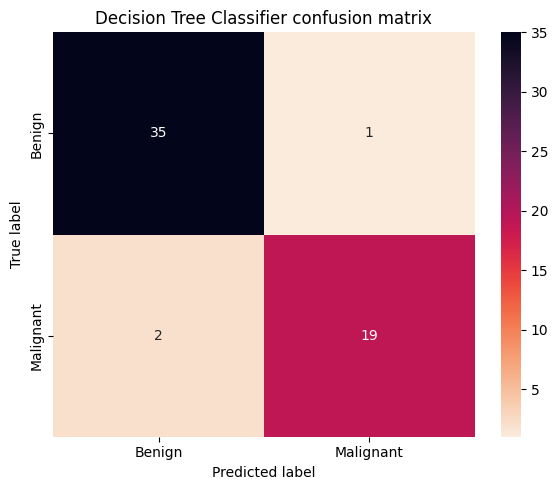

In [6]:
print("Evaluating all splits...")
for name, split in splits.items():
    print(f"\n{'-'*50}\nEvaluating {name.replace('_', ' ')}")
    evaluate_tree(
        split['feature_train'], 
        split['label_train'],
        split['feature_test'],
        split['label_test']
    )

# The depth and accuracy of a decision tree



Analyzing max_depth for 80/20 split...


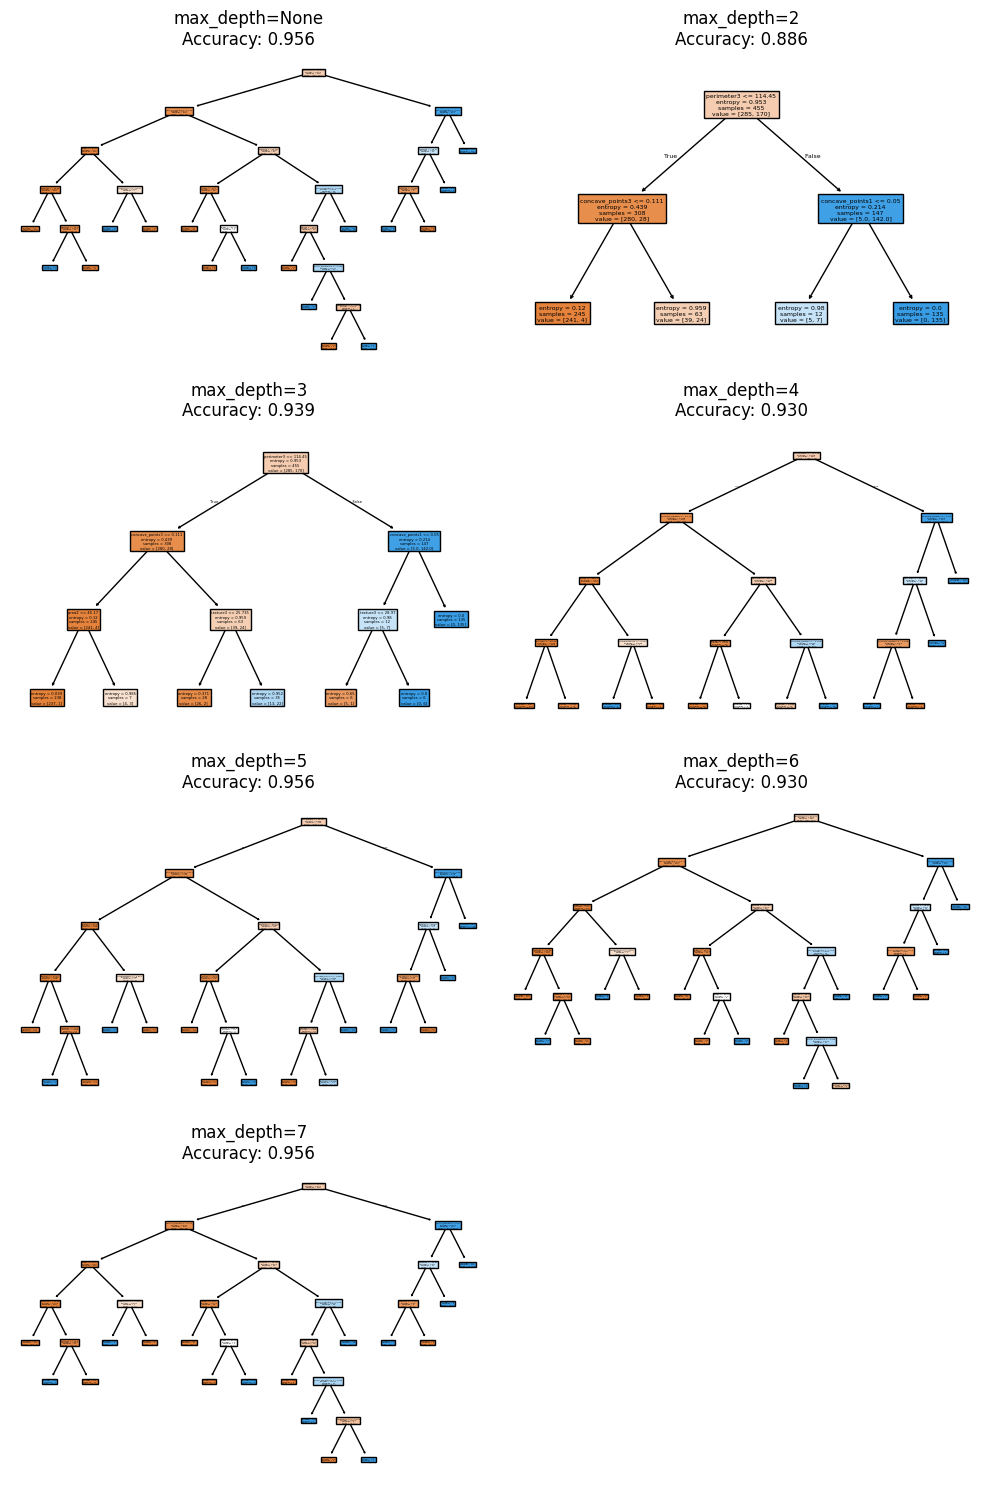

In [7]:
print("\n\nAnalyzing max_depth for 80/20 split...")
X_train = splits['train_80_test_20']['feature_train']
y_train = splits['train_80_test_20']['label_train']
X_test = splits['train_80_test_20']['feature_test']
y_test = splits['train_80_test_20']['label_test']

max_depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

plt.figure(figsize=(10, 15))
for i, depth in enumerate(max_depths, 1):
    plt.subplot(4, 2, i)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    acc = dt.score(X_test, y_test)
    accuracies.append(acc)
    
    plot_tree(dt, feature_names=features.columns, filled=True)
    plt.title(f"max_depth={depth}\nAccuracy: {acc:.3f}")

plt.tight_layout()
plt.show()



max_depth	Accuracy
None    	0.9561
2       	0.8860
3       	0.9386
4       	0.9298
5       	0.9561
6       	0.9298
7       	0.9561


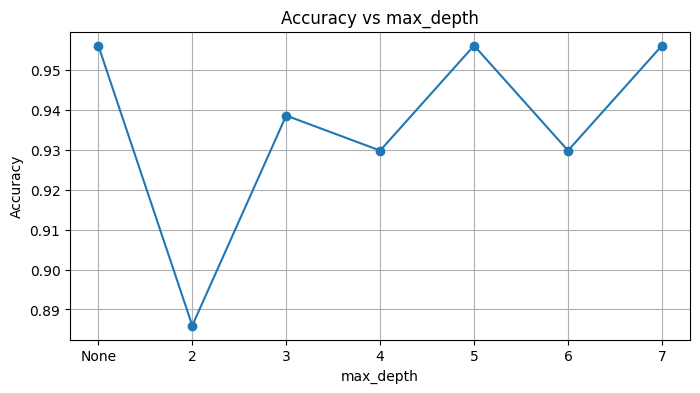

In [8]:
print("\nmax_depth\tAccuracy")
for depth, acc in zip(max_depths, accuracies):
    print(f"{str(depth).ljust(8)}\t{acc:.4f}")

plt.figure(figsize=(8, 4))
plt.plot([str(d) if d else 'None' for d in max_depths], accuracies, 'o-')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth')
plt.grid(True)
plt.show()